# Convolutional Neural Networks Fundamentals

## Initialization

In [324]:
# Load libraries

# OS
import time
from glob import glob
import itertools

# Data manipulation
import numpy as np
import cv2
import imgaug
import imgaug.augmenters as iaa

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Modeling
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.optim import Adam
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchvision import datasets
from torchsummary import summary

print(torch.__version__)
print(cv2.__version__)
print(imgaug.__version__) 
!nvidia-smi # check if GPU is available
%matplotlib inline

2.2.0
4.9.0
0.4.0
zsh:1: command not found: nvidia-smi


In [182]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cpu


In [183]:
# Create toy image dataset NCHW (2,1,4,4) and labels (2,1)
X_train = torch.tensor(
    [ # 2 Samples
        [ # 1 Channel
            [ # 4x4 Image
                [1,2,3,4],
                [2,3,4,5],
                [5,6,7,8],
                [1,3,4,5]
            ]
        ],
        [
            [
                [-1,2,3,-4],
                [2,-3,4,5],
                [-5,6,-7,8],
                [-1,-3,-4,-5]
            ]
        ]
    ]
).to(device).float()

# Divide by max value to get values between -1 and 1
X_train /= X_train.max()

y_train = torch.tensor(
    [0,1]
).to(device).float()

In [184]:
# Define model architecture
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 1, kernel_size=3), # 1 input channel, 1 output channel, 3x3 kernel
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1, 1),
        nn.Sigmoid()
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [185]:
# Print summary of the model
model, _, _ = get_model()
summary(model, X_train.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 1, 2, 2]              10
         MaxPool2d-2              [-1, 1, 1, 1]               0
              ReLU-3              [-1, 1, 1, 1]               0
           Flatten-4                    [-1, 1]               0
            Linear-5                    [-1, 1]               2
           Sigmoid-6                    [-1, 1]               0
Total params: 12
Trainable params: 12
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [186]:
# Create a function to train a batch of data
def train_batch(model, loss_fn, optimizer, x, y):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred.squeeze(0), y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [187]:
# Define a dataloader
train_dl = DataLoader(TensorDataset(X_train, y_train))

In [188]:
# Train model
model, loss_fn, optimizer = get_model()
n_epochs = 2_000

for epoch in range(n_epochs):
    for x, y in train_dl:
        loss = train_batch(model, loss_fn, optimizer, x, y)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss:.4f}")

Epoch 0: Loss 0.3907


Epoch 100: Loss 0.3974
Epoch 200: Loss 0.4184
Epoch 300: Loss 0.4385
Epoch 400: Loss 0.4576
Epoch 500: Loss 0.4758
Epoch 600: Loss 0.4930
Epoch 700: Loss 0.5092
Epoch 800: Loss 0.5243
Epoch 900: Loss 0.5384
Epoch 1000: Loss 0.5516
Epoch 1100: Loss 0.5637
Epoch 1200: Loss 0.5750
Epoch 1300: Loss 0.5854
Epoch 1400: Loss 0.5949
Epoch 1500: Loss 0.6037
Epoch 1600: Loss 0.6118
Epoch 1700: Loss 0.6192
Epoch 1800: Loss 0.6259
Epoch 1900: Loss 0.6321


In [189]:
# Perform inference on the first sample
model.eval()

with torch.no_grad():
    y_pred = model(X_train[0].unsqueeze(0))
    print(y_pred)

tensor([[0.5285]])


## Image classification using deep CNNs

In [190]:
# Set data folder
data_folder = './data/FMNIST'

# Get the training and validation sets
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
fmnist_val = datasets.FashionMNIST(data_folder, download=True, train=False)

# Store images and labels
imgs = fmnist.data
labels = fmnist.targets
imgs_val = fmnist_val.data
labels_val = fmnist_val.targets

In [191]:
# Create Dataset class to fetch images and labels
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.view(-1, 1, 28, 28).float() / 255.0
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx].to(device), self.y[idx].to(device)

In [192]:
# Create a function to retrieve the dataloaders
def load_data(batch_size):
    train_dataset = FMNISTDataset(imgs, labels)
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = FMNISTDataset(imgs_val, labels_val)
    val_dl = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    return train_dl, val_dl

In [193]:
# Create a function to train the model on a batch of data
def train_batch(model, loss_fn, optimizer, x, y):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [194]:
# Create a function to calculate the accuracy of the model
@torch.no_grad()
def accuracy(model, x, y):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [195]:
# Create a function to calculate the validation loss
@torch.no_grad()
def val_loss(model, x, y):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [196]:
# Create a function to create a simple CNN model architecture
def create_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [197]:
# Print summary of the model
model_summ, _, _ = create_model()
summary(model_summ, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

In [198]:
# Train the model
model, loss_fn, optimizer = create_model()
batch_size = 32
train_dl, val_dl = load_data(batch_size)
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1


Epoch 2
Epoch 3
Epoch 4
Epoch 5
Time: 478.33s


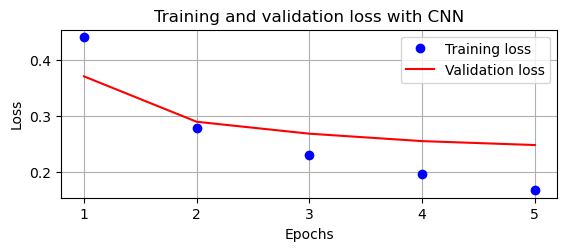

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_24664/637708941.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


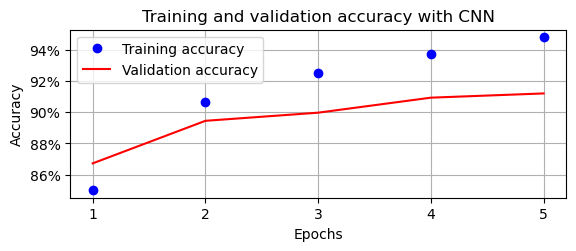

In [199]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Data Augmentation

In [200]:
# Create function to plot an image
def plot_img(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()

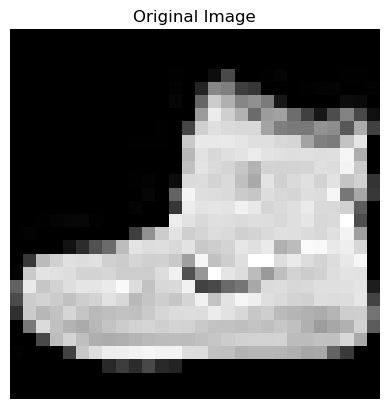

In [201]:
# Plot original image
plot_img(imgs[0], "Original Image")

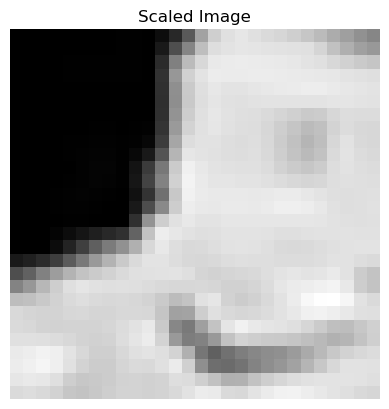

In [202]:
# Define scaling augmentation object
aug = iaa.Affine(scale=2)

# Apply augmentation
plot_img(aug.augment_image(imgs[0].numpy()), "Scaled Image")

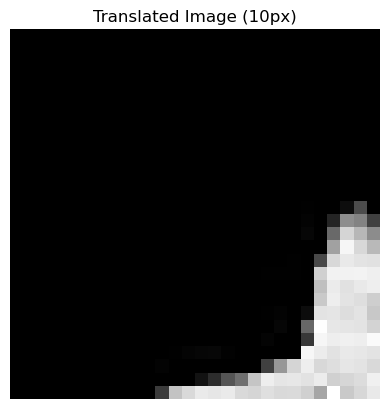

In [203]:
# Define translation augmentation object
aug = iaa.Affine(translate_px=10)

# Apply augmentation
plot_img(aug.augment_image(imgs[0].numpy()), "Translated Image (10px)")

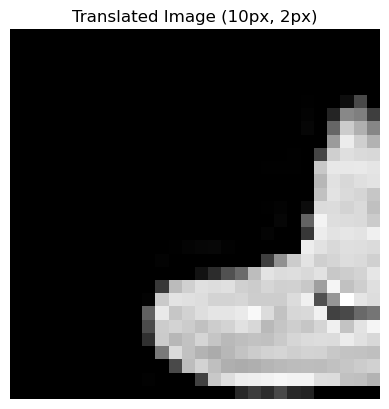

In [204]:
# Define a translation augmentation object
aug = iaa.Affine(translate_px={"x": 10, "y": 2})

# Apply augmentation
plot_img(aug.augment_image(imgs[0].numpy()), "Translated Image (10px, 2px)")

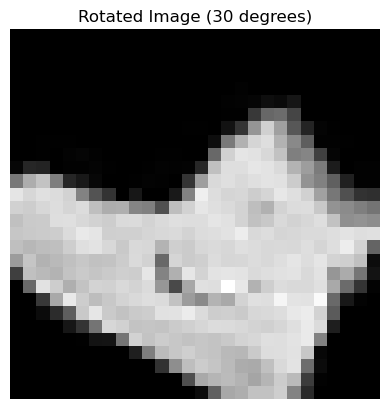

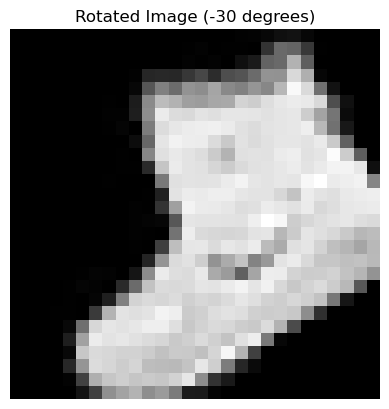

In [205]:
# aug = iaa.Affine(rotate=-30)
# plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
# plt.title('Rotation of image by -30 degrees') 

# Define a rotation augmentation objects
aug30 = iaa.Affine(rotate=30)
aug30m = iaa.Affine(rotate=-30)

# Apply augmentation
plot_img(aug30.augment_image(imgs[0].numpy()), "Rotated Image (30 degrees)")
plot_img(aug30m.augment_image(imgs[0].numpy()), "Rotated Image (-30 degrees)")

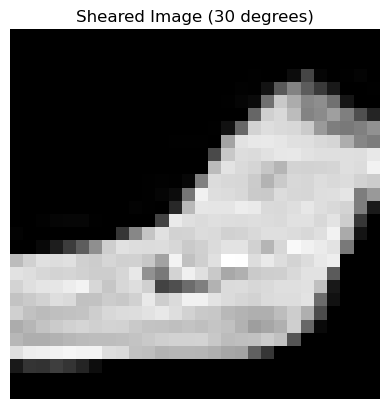

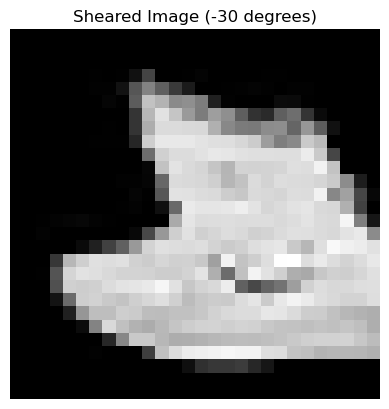

In [206]:
# Define a shear augmentation objects
aug30 = iaa.Affine(shear=30)
aug30m = iaa.Affine(shear=-30)

# Apply augmentation
plot_img(aug30.augment_image(imgs[0].numpy()), "Sheared Image (30 degrees)")
plot_img(aug30m.augment_image(imgs[0].numpy()), "Sheared Image (-30 degrees)")

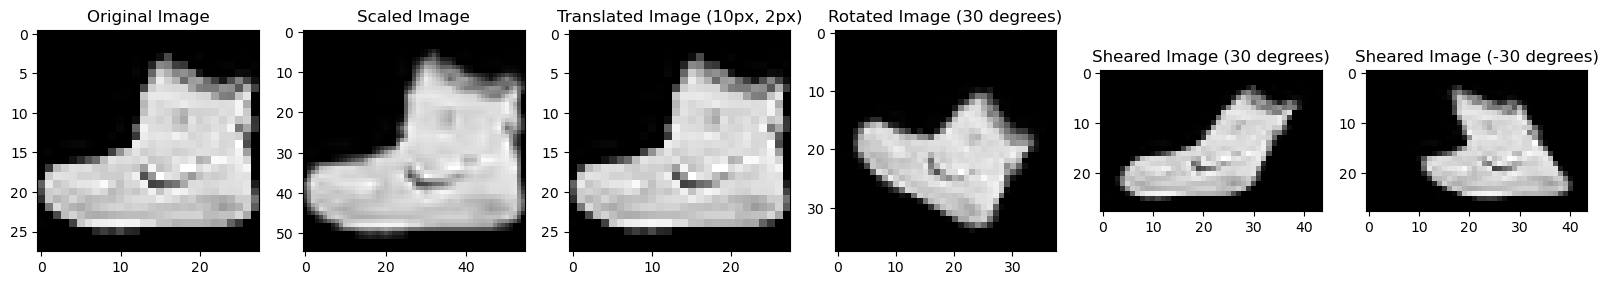

In [207]:
# Use fit_output parameter to fit the output to the input size
plt.figure(figsize=(20,20))
plt.subplot(161)
plt.imshow(imgs[0], cmap='gray')
plt.title('Original Image')
plt.subplot(162)
aug = iaa.Affine(scale=2, fit_output=True)
plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.title('Scaled Image')
plt.subplot(163)
aug = iaa.Affine(translate_px={'x':10,'y':2}, fit_output=True)
plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.title('Translated Image (10px, 2px)')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True)
plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.title('Rotated Image (30 degrees)')
plt.subplot(165)
aug = iaa.Affine(shear=30, fit_output=True)
plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.title('Sheared Image (30 degrees)')
plt.subplot(166)
aug = iaa.Affine(shear=-30, fit_output=True)
plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.title('Sheared Image (-30 degrees)')
plt.show()

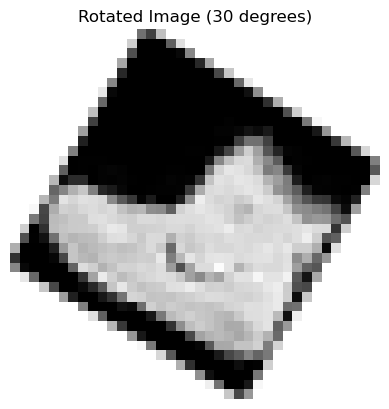

In [208]:
# Define a rotation augmentation object using cval parameter
aug = iaa.Affine(rotate=30, fit_output=True, cval=255)

# Apply augmentation
plot_img(aug.augment_image(imgs[0].numpy()), "Rotated Image (30 degrees)")

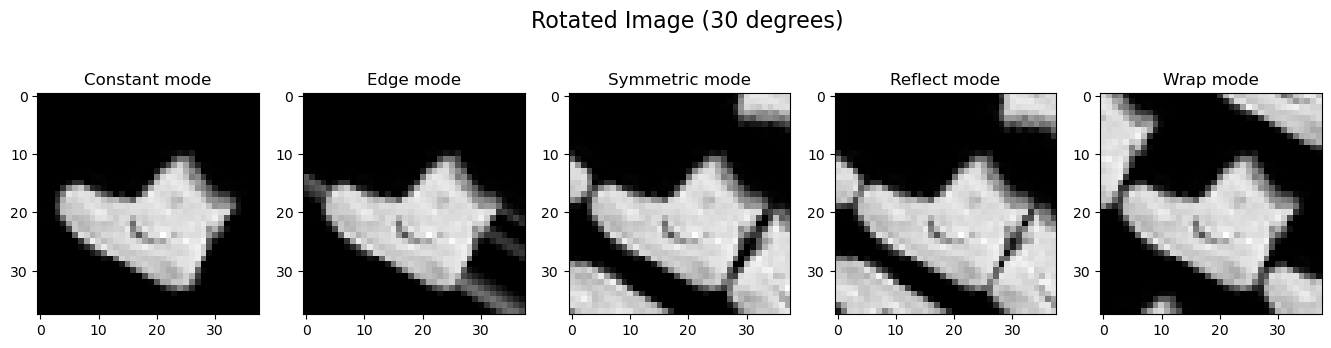

In [209]:
# Showcase the effect of different modes
plt.figure(figsize=(20,4))
plt.suptitle('Rotated Image (30 degrees)', fontsize=16, x=0.45)
plt.subplot(161)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.title('Constant mode')
plt.subplot(162)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='edge')
plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.title('Edge mode')
plt.subplot(163)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='symmetric')
plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.title('Symmetric mode')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='reflect')
plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.title('Reflect mode')
plt.subplot(165)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='wrap')
plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.title('Wrap mode')
plt.show()


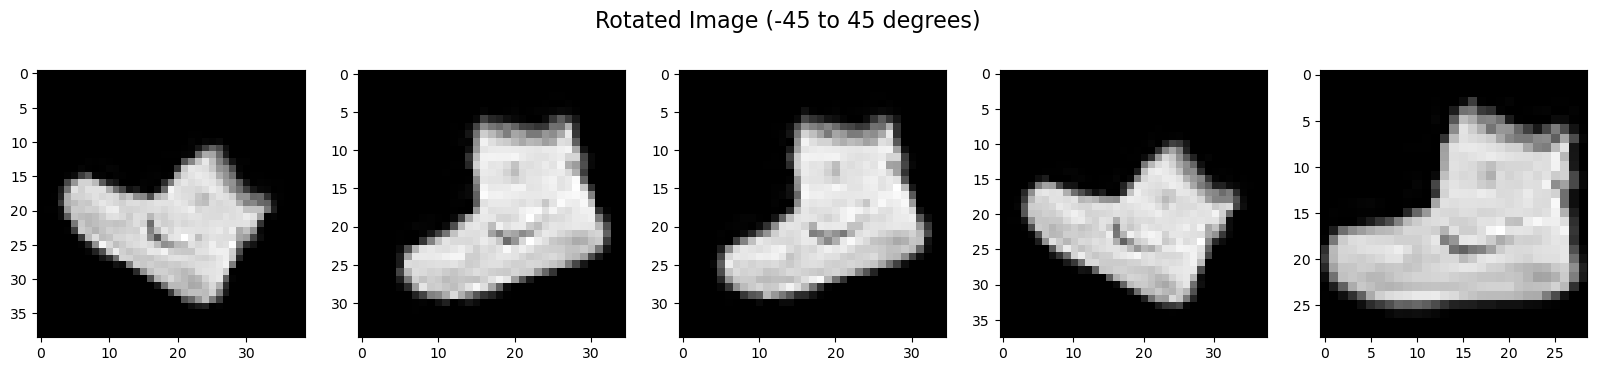

In [210]:
# Showcase the effect of range of rotation
plt.figure(figsize=(20,4))
plt.suptitle('Rotated Image (-45 to 45 degrees)', fontsize=16, x=0.5)
for i in range(5):
    plt.subplot(151+i)
    aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
    plt.imshow(aug.augment_image(imgs[0].numpy()), cmap='gray')
plt.show()

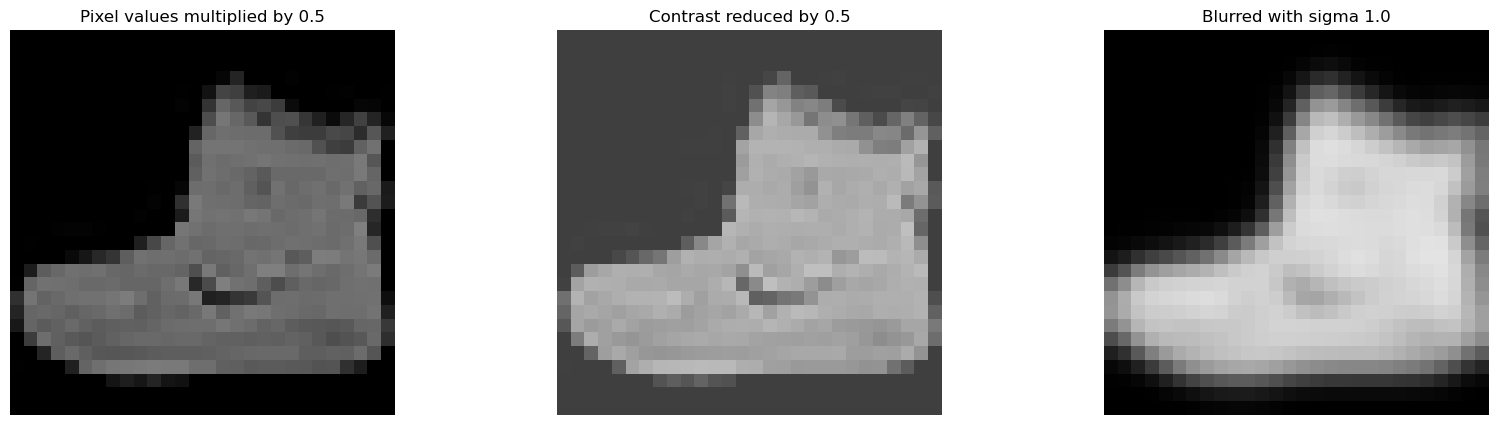

In [211]:
# Define Multiply, LinearContrast and GaussianBlur augmentations objects
aug_mul = iaa.Multiply(0.5)
aug_lin = iaa.LinearContrast(0.5)
aug_gau = iaa.GaussianBlur(sigma=1.0)

# Apply augmentations
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.axis('off')
plt.imshow(aug_mul.augment_image(imgs[0].numpy()), cmap='gray', vmin=0, vmax=255)
plt.title('Pixel values multiplied by 0.5')
plt.subplot(132)
plt.axis('off')
plt.imshow(aug_lin.augment_image(imgs[0].numpy()), cmap='gray', vmin=0, vmax=255)
plt.title('Contrast reduced by 0.5')
plt.subplot(133)
plt.axis('off')
plt.imshow(aug_gau.augment_image(imgs[0].numpy()), cmap='gray', vmin=0, vmax=255)
plt.title('Blurred with sigma 1.0')
plt.show()

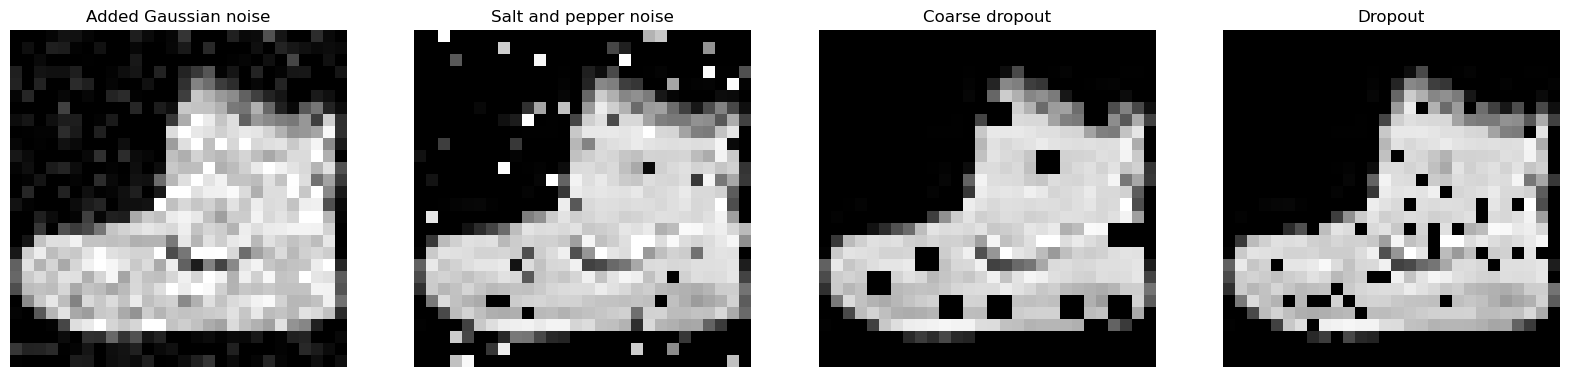

In [212]:
# Define AdditiveGaussianNoise, SaltAndPepper, CoarseDropout and Dropout augmentations objects
aug_noise = iaa.AdditiveGaussianNoise(scale=0.1*255)
aug_sp = iaa.SaltAndPepper(0.1)
aug_cd = iaa.CoarseDropout(0.1, size_percent=0.5)
aug_do = iaa.Dropout(0.1)

# Apply augmentations
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.axis('off')
plt.imshow(aug_noise.augment_image(imgs[0].numpy()), cmap='gray', vmin=0, vmax=255)
plt.title('Added Gaussian noise')
plt.subplot(142)
plt.axis('off')
plt.imshow(aug_sp.augment_image(imgs[0].numpy()), cmap='gray', vmin=0, vmax=255)
plt.title('Salt and pepper noise')
plt.subplot(143)
plt.axis('off')
plt.imshow(aug_cd.augment_image(imgs[0].numpy()), cmap='gray', vmin=0, vmax=255)
plt.title('Coarse dropout')
plt.subplot(144)
plt.axis('off')
plt.imshow(aug_do.augment_image(imgs[0].numpy()), cmap='gray', vmin=0, vmax=255)
plt.title('Dropout')
plt.show()

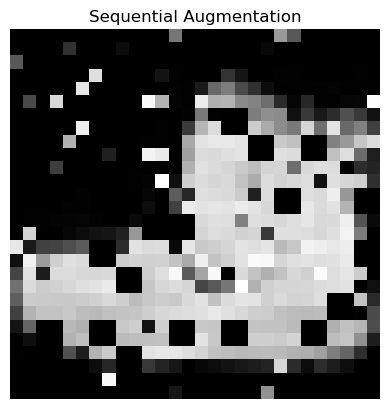

In [213]:
# Define Sequential augmentation object
aug = iaa.Sequential([
    iaa.Affine(rotate=(-45, 45)),
    iaa.SaltAndPepper(0.1),
    iaa.CoarseDropout(0.1, size_percent=0.5),
])

# Apply augmentation
plot_img(aug.augment_image(imgs[0].numpy()), "Sequential Augmentation")

### Augmentation on a Batch of images and the use of collate_fn

In [238]:
# Define Sequential augmentation object
aug = iaa.Sequential([
    iaa.Affine(rotate=(-45, 45)),
    iaa.SaltAndPepper(0.1),
    iaa.CoarseDropout(0.1, size_percent=0.5),
], random_order=True)

In [245]:
# Perform augmentation on a batch of images one by one
%time
for i in range(32):
    aug.augment_image(imgs[i].numpy())

CPU times: user 2 µs, sys: 5 µs, total: 7 µs
Wall time: 16 µs


In [246]:
# Perform augmentation on a batch of images at once
%time
x = aug.augment_images(imgs[:32].numpy())

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs


In [277]:
# Modify the Dataset class to include augmentation in the collate_fn
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def collate_fn(self, batch):
        imgs, labels = list(zip(*batch))
        imgs = np.array(imgs)
        if self.aug:
            imgs = self.aug.augment_images(imgs)
        imgs = torch.tensor(imgs).float().to(device) / 255.0
        imgs = imgs[:, None, :, :]
        labels = torch.tensor(labels).to(device)
        return imgs, labels

In [278]:
# Define Sequential augmentation object
aug = iaa.Sequential([
    iaa.Affine(translate_px={"x": (-10, 10)}, mode='constant'),
    iaa.Affine(rotate=(-30, 30)),
    iaa.SaltAndPepper(0.1),
    iaa.CoarseDropout(0.1, size_percent=0.5),
])

# Create dataloaders with augmentation
train_dataset = FMNISTDataset(imgs, labels, aug)
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset.collate_fn)
val_dataset = FMNISTDataset(imgs_val, labels_val)
val_dl = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True, collate_fn=val_dataset.collate_fn)

# Train the model
model, loss_fn, optimizer = create_model()
losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    # Train on batches
    for x, y in train_dl:
        batch_loss = train_batch(model, loss_fn, optimizer, x, y)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(model, x, y)
        epoch_accuracies.extend(batch_accuracy)
    val_x, val_y = next(iter(val_dl))
    val_accuracy = accuracy(model, val_x, val_y)
    val_epoch_loss = val_loss(model, val_x, val_y)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))
    val_accuracies.append(np.mean(val_accuracy))

end = time.time()
print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Time: 619.33s


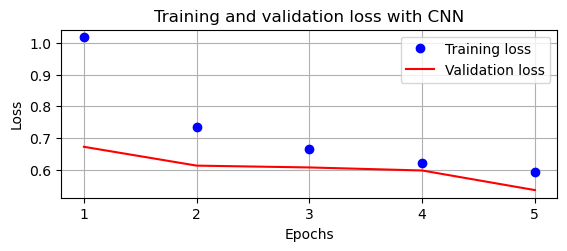

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_24664/637708941.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


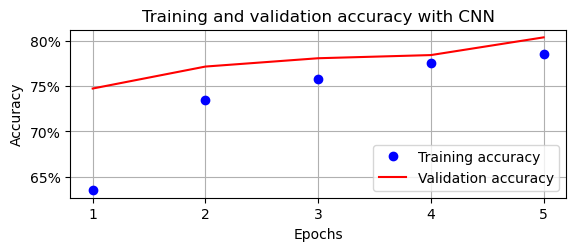

In [279]:
# Plot the loss and accuracy on the training and validation sets
%matplotlib inline
epochs_list = np.arange(1, epochs+1)
plt.subplot(211)
plt.plot(epochs_list, losses, 'bo', label='Training loss')
plt.plot(epochs_list, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs_list, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs_list, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

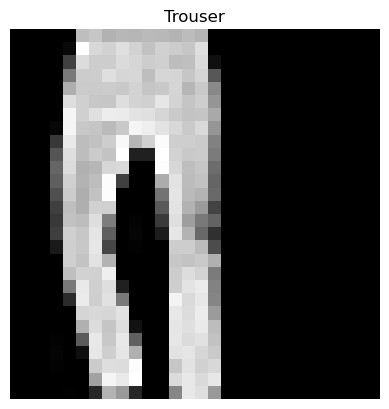

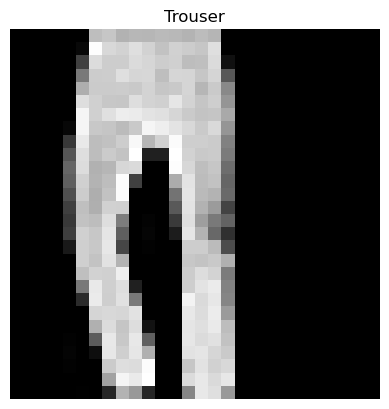

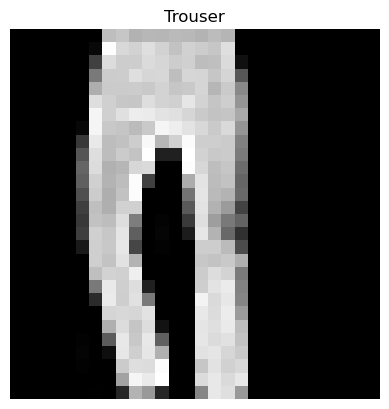

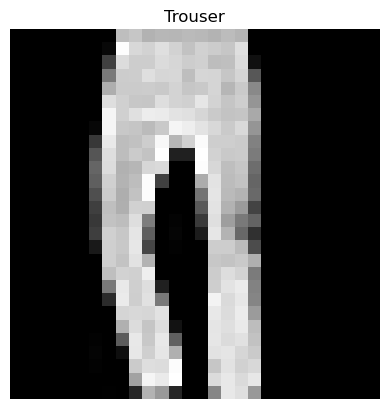

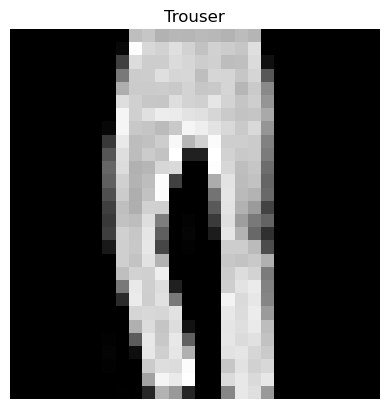

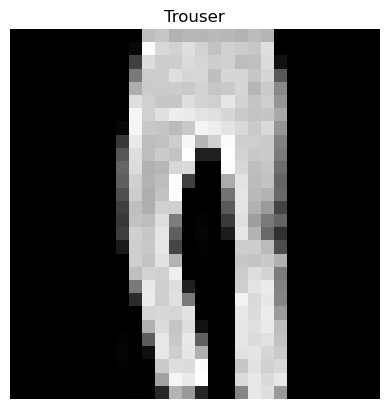

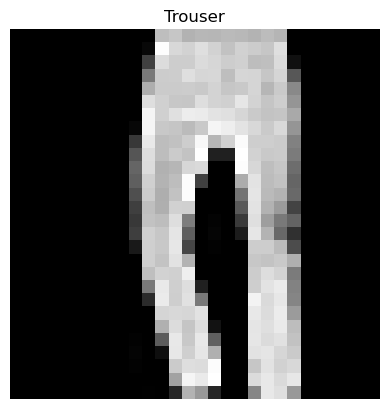

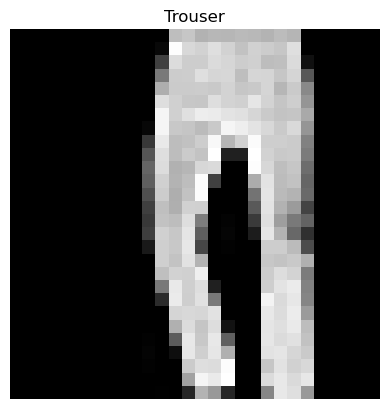

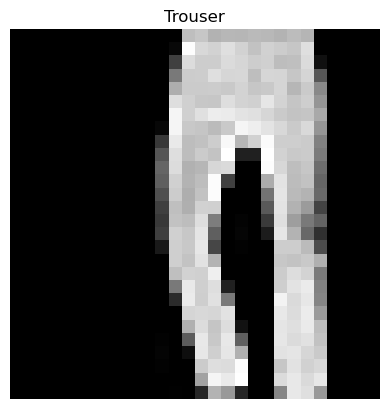

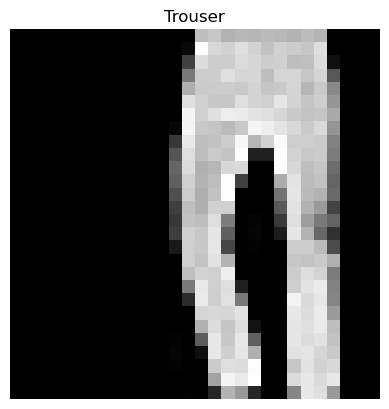

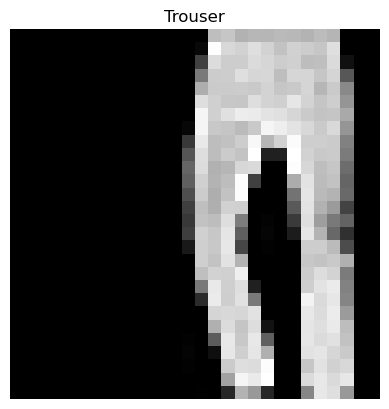

In [280]:
# Make predictions on translated images to notice how augmentation affects the model
preds = []
ix = 24300
for px in range(-5,6):
    img = imgs[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plot_img(img2, fmnist.classes[pred[0].argmax()])

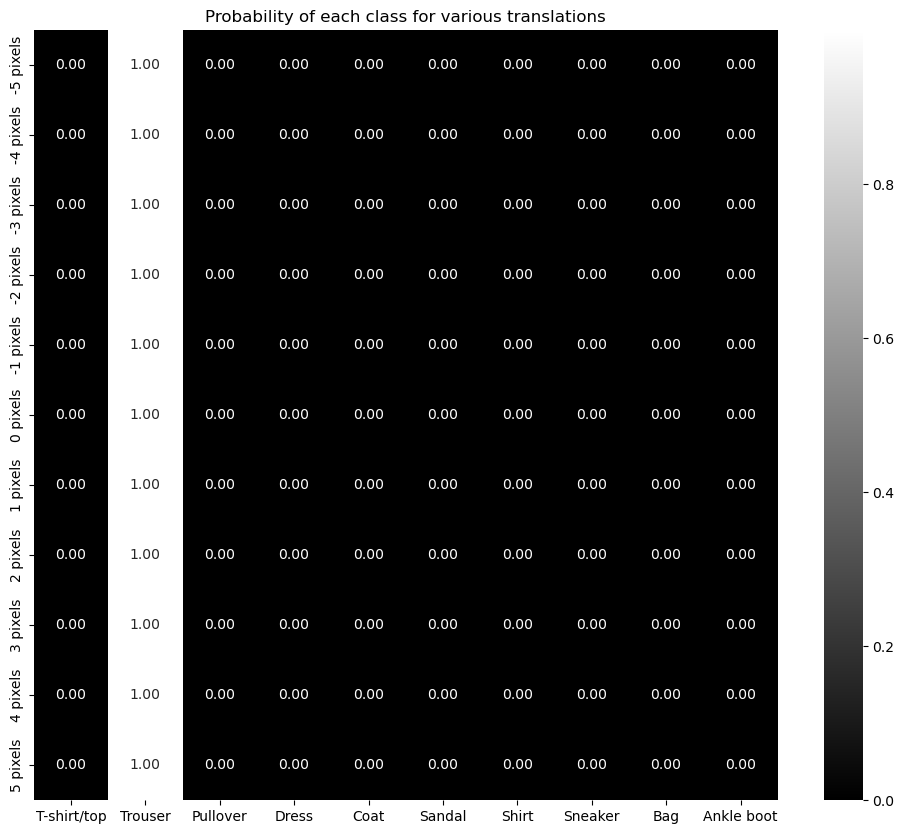

In [281]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(
    np.array(preds).reshape(11, 10),
    annot=True,
    ax=ax,
    fmt='.2f',
    xticklabels=fmnist.classes,
    yticklabels=[f'{str(i)} pixels' for i in range(-5, 6)],
    cmap='gray',
)
plt.show()

## Visualizing the outcome of features

In [286]:
# Create a class to load the images
scale_transformation = iaa.Sequential(iaa.Resize(28)) # Resize the image to 28x28

class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)

    def __len__(self): return len(self.files)

    def __getitem__(self, ix):
        file = self.files[ix]
        image = scale_transformation.augment_image(cv2.imread(file)[:,:,0]) # Read image and apply 28x28 resize
        image = image[None] # Add channel dimension
        label = file.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - image/255).to(device).float(), torch.tensor([label]).float().to(device)

In [292]:
# Load the images
data = XO('./data/XO/*')

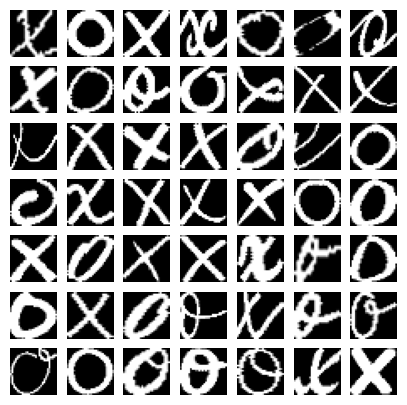

In [293]:
# Plot sample images
fig, ax = plt.subplots(7, 7, figsize=(5,5))
for i, j in itertools.product(range(7), range(7)):
    ax[i,j].imshow(data[i*7+j][0][0].cpu(), cmap='gray')
    ax[i,j].axis('off')
plt.show()

In [291]:
# Define model architecture
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [294]:
# Print model summary
model, _, _ = get_model()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 1]             257
          Sigmoid-11                    [-1, 1]               0
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [296]:
# Create a function to train the model on a batch of data
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

# Create a function to calculate the accuracy of the model
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

# Create a function to calculate the validation loss
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [297]:
# Train the model
model, loss_fn, optimizer = get_model()
batch_size = 32
train_dl = DataLoader(data, batch_size=batch_size, drop_last=True, shuffle=True)

losses, val_losses, accuracies, val_accuracies = [], [], [], []
start = time.time()
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    for x, y in train_dl:
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
        batch_accuracy = accuracy(x, y, model)
        epoch_accuracies.extend(batch_accuracy)
    epoch_loss = np.array(epoch_losses).mean()
    losses.append(epoch_loss)
    accuracies.append(np.mean(epoch_accuracies))

end = time.time()

print(f"Time: {end - start:.2f}s")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Time: 23.05s


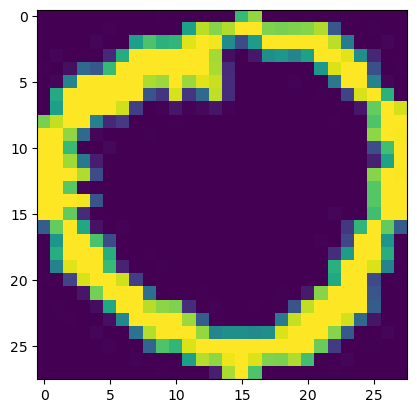

In [301]:
# Fetch an image to check the filter activations
im, c = train_dl.dataset[4]
plt.imshow(im[0].cpu())
plt.show()

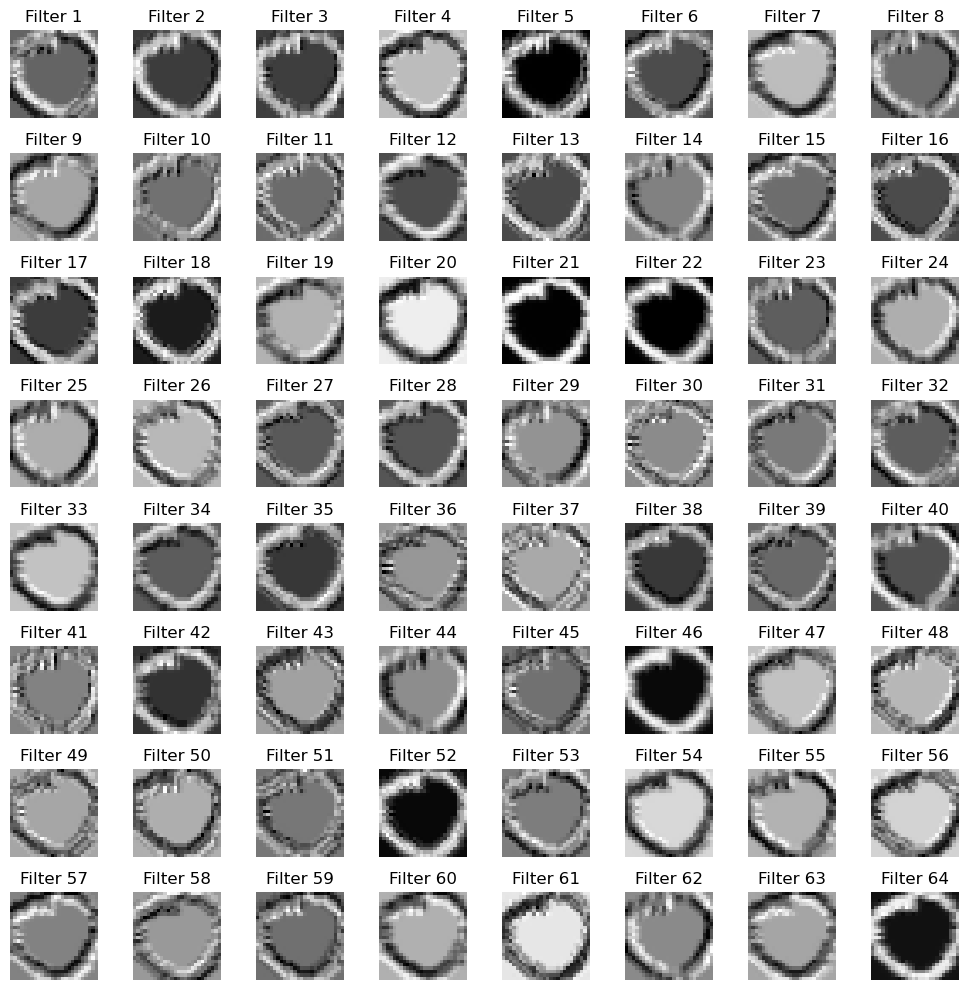

In [308]:
# Pass the image through the model and fetch the activations for the first layer
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach().cpu().numpy()

# Plot the activations
fig, ax = plt.subplots(8, 8, figsize=(10,10))
for i, j in itertools.product(range(8), range(8)):
    ax[i,j].set_title(f'Filter {i*8+j+1}')
    ax[i,j].imshow(intermediate_output[i*8+j], cmap='gray')
    ax[i,j].axis('off')
plt.tight_layout()
plt.show()

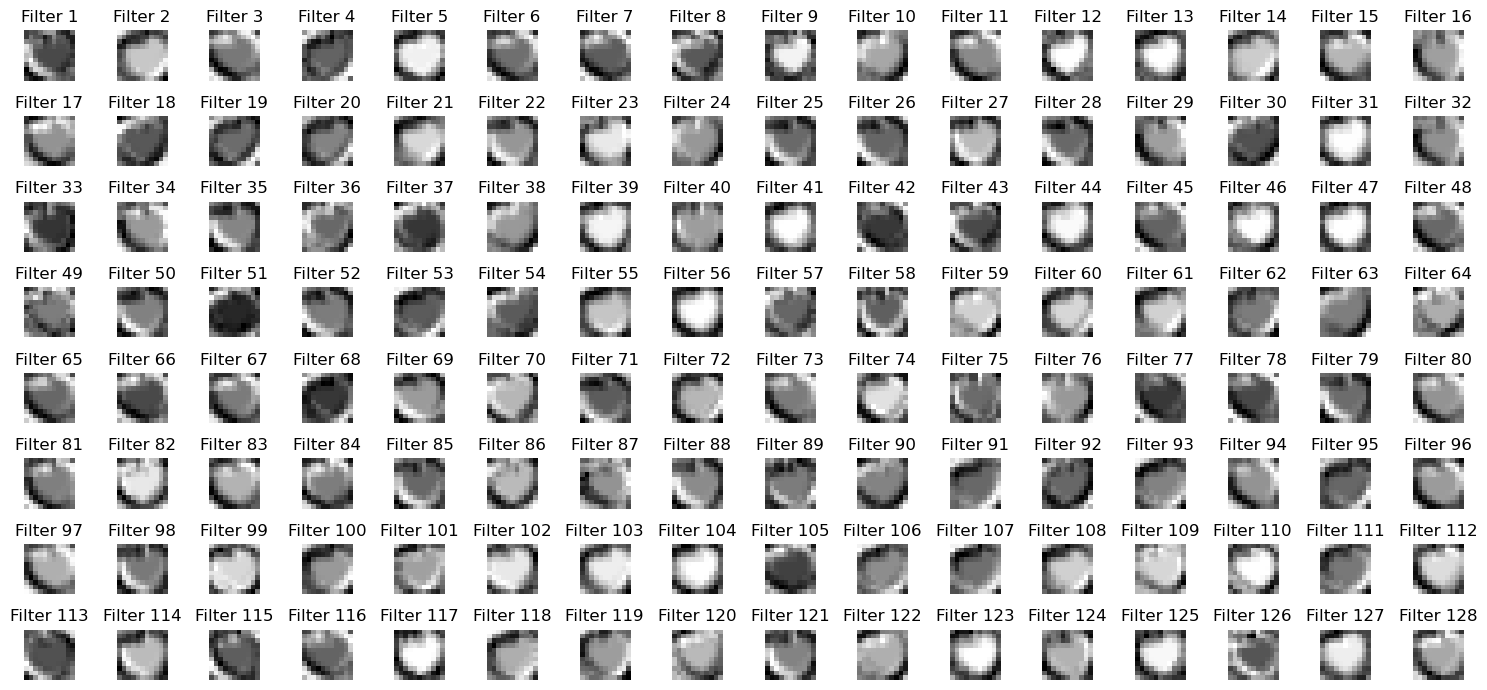

In [309]:
# Pass the image through the model and fetch the activations for the second layer
second_layer = nn.Sequential(*list(model.children())[:4])
intermediate_output = second_layer(im[None])[0].detach().cpu().numpy()

# Plot the activations
fig, ax = plt.subplots(8, 16, figsize=(15,7))
for i, j in itertools.product(range(8), range(16)):
    ax[i,j].set_title(f'Filter {i*16+j+1}')
    ax[i,j].imshow(intermediate_output[i*16+j], cmap='gray')
    ax[i,j].axis('off')
plt.tight_layout()
plt.show()

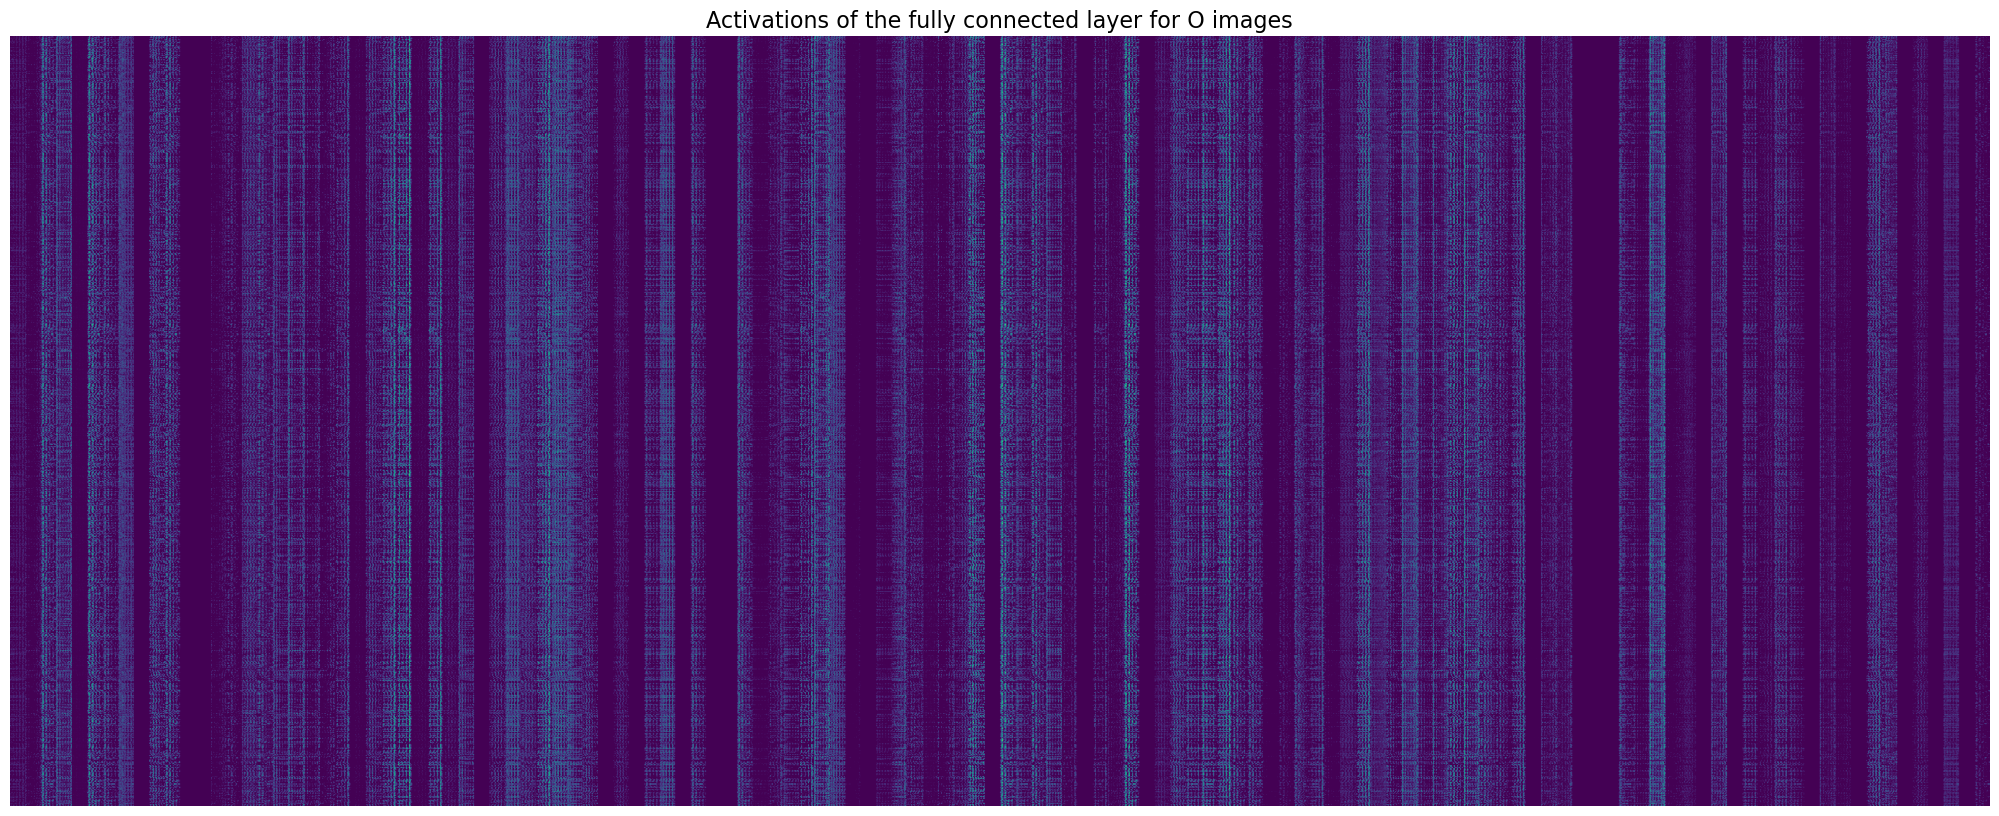

In [322]:
# Create a custom dataloader to fetch the O images
custom_dl = DataLoader(data, batch_size=2498, drop_last=True, shuffle=True)
image, label = next(iter(custom_dl))

# Filter out only O labeled images
o_image = image[label==0]
o_image = o_image.view(len(o_image),1,28,28)

# Pass the image through the model and fetch the activations for the third layer
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_output = flatten_layer(o_image).detach()

# Plot the activations
plt.figure(figsize=(100,10))
plt.title('Activations of the fully connected layer for O images', fontsize=16)
plt.imshow(flatten_output.cpu().numpy())
plt.axis('off')
plt.show()